# Modzy Jobs API with Python SDK  
In this notebook, we will use the Modzy Python SDK to make an inference call to a model.

For more detailed usage documenation for our Python SDK, visit our **[GitHub page](https://github.com/modzy/sdk-python)**. 

### 1. Environment Set Up

Create a virtual environment (venv, conda, or other preferred virtual environment) with Python 3.6 or newer. 

Pip install the following packages in your environment. 

* modzy-sdk>=0.10.0
* opencv-python==4.5.2.54
* numpy==1.21.0
* matplotlib==3.4.2

And install Jupyter Notebooks in your preferred environment using the appropriate **[install instructions](https://jupyter.org/install)**.

### 2. Import Modzy SDK and Initialize Client

Insert your instance URL and personal API Key to establish connection to the Modzy API Client

In [1]:
# Import Libraries
import cv2
from pprint import pprint
from matplotlib import pyplot as plt
from modzy import ApiClient, error
from utils import display_rle_mask

#### Initialize Modzy API Client

In [ ]:
# the url we will use for authentication
'''
Example: "https://test.modzy.url"
'''
API_URL = "https://<your.modzy.url>"
# the api key we will be using for authentication -- make sure to paste in your personal API access key below
API_KEY = "<your.api.key>"
    
# setup our API Client
client = ApiClient(base_url=API_URL, api_key=API_KEY)

### 3. Discover Available Models
In this notebook, we will run inference for the Automobile Classification Model

In [7]:
# Query model by name
auto_model_info = client.models.get_by_name("Image-Based Geolocation")
pprint(auto_model_info)

{'author': 'Modzy',
 'description': 'This model returns the predicted geographical location of a '
                'given image at both a class and regional level.',
 'expirationDate': '2021-10-20T00:00:00.000+00:00',
 'features': [{'description': 'This model has a built-in explainability '
                              'feature. Click '
                              '[here](https://arxiv.org/abs/1602.04938) to '
                              'read more about model explainability.',
               'identifier': 'built-in-explainability',
               'name': 'Explainable'}],
 'images': [{'caption': 'Image-Based Geolocation',
             'relationType': 'background',
             'url': '/modzy-images/aevbu1h3yw/image_background.png'},
            {'caption': 'Image-Based Geolocation',
             'relationType': 'card',
             'url': '/modzy-images/aevbu1h3yw/image_card.png'},
            {'caption': 'Image-Based Geolocation',
             'relationType': 'thumbnail',
       

In [30]:
# Define Variables for Inference
MODEL_ID = auto_model_info["modelId"]
MODEL_VERSION = auto_model_info["latestVersion"]
INPUT_FILENAME = list(client.models.get_version_input_sample(MODEL_ID, MODEL_VERSION)["input"]["sources"]["0001"].keys())[0]
sources = {INPUT_FILENAME: "./nyc.jpg"}

### 4. Submit Inference to Model

#### Helper Function
Below is a helper function we will use to submit inference jobs to the Modzy platform and return the model output using the `submit_files` method. For additional job submission methods, visit our **[docs page](https://docs.modzy.com/docs/python)**.

In [1]:
def get_model_output(model_identifier, model_version, data_sources, explain=False):
    """
    Args:
        model_identifier: model identifier (string)
        model_version: model version (string)
        data_sources: dictionary with the appropriate filename --> local file key-value pairs
        explain: boolean variable, defaults to False. If true, model will return explainable result
    """
    job = client.jobs.submit_file(model_identifier, model_version, data_sources, explain)
    result = client.results.block_until_complete(job, timeout=None)    
    model_output = result.get_first_outputs()['results.json']
    
    return model_output

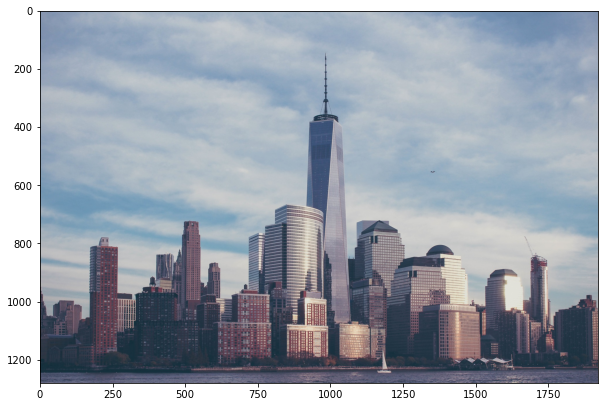

In [32]:
# Visualize image to use for inference
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(cv2.imread("./nyc.jpg"),cv2.COLOR_BGR2RGB));

**Image source**: https://pixabay.com/photos/world-trade-center-buildings-1210003/

**Pixabay License**: https://pixabay.com/service/license/

In [33]:
model_results = get_model_output(MODEL_ID, MODEL_VERSION, sources, explain=True)
non_explainable_results = model_results["data"]["result"]
pprint(non_explainable_results)

{'classPredictions': [{'class': 'New York, North America',
                       'score': 1.0},
                      {'class': 'Chicago, North America',
                       'score': 0.0},
                      {'class': 'Hong Kong, Asia',
                       'score': 0.0},
                      {'class': 'Toronto, North America',
                       'score': 0.0},
                      {'class': 'Saint Petersburg, Eastern-Europe',
                       'score': 0.0}]}


### 5. Plot Explainability Mask on Image

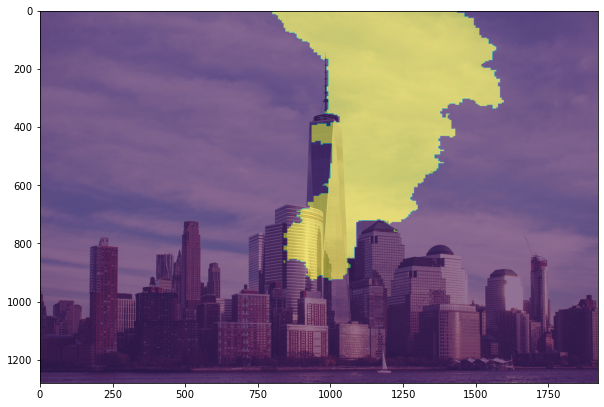

In [34]:
# Plot RLE Explainability mask over image. This model uses LIME to produce an explainable output RLE mask
rle_counts = model_results["data"]["explanation"]["maskRLE"]
img = cv2.cvtColor(cv2.imread('./nyc.jpg'),cv2.COLOR_BGR2RGB)
mask = display_rle_mask(img,rle_counts)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(mask,alpha=0.5)
plt.show()